In [1]:
import os
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn import tree
import numpy as np
import pandas as pd
import random
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [2]:
max_T = 100
thresh = 1e-4 # Hyper-
#set random seed to make results reproducible
seed = 1234
np.random.seed(seed)
random.seed(seed)

# Read Dataset

In [3]:
path = "../predict-responsibly/data/"
dataset = "adult"
protected_feature = "sex"
K = 1
db = np.load(os.path.join(path,dataset,"{}{}_{}.npz".format(dataset,K,protected_feature)))

## partition X according to f0

In [4]:
x_val = db["x_train"]
y_val = db["y_train"]
x_test = db["x_test"]
y_test = db["y_test"]

In [5]:
def res(p, y):
    # 有noise 吧？？？？？我用这个就拟合不了了
    return y * ((p>=0.1)/(p + 1e-20) + (p<0.1) * (20 - 100  * p)) +\
(1-y) * ((p < 0.9)/(1 - p + 1e-20) + (p>=0.9) * (100 * p - 80))

In [6]:
# logits = net.output[:,1] - net.output[:,0]
# in our case, we get the logits directly
logits = np.log(db["ydm_train"]/(1-db["ydm_train"]))
test_logits = np.log(db["ydm_test"]/(1-db["ydm_test"]))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


In [7]:
best_epoch, best_acc = -1,0
# get the validation index

valid_index = np.arange(len(x_val))
#use budget % of the validation set for training
valid_index =random.sample(list(valid_index), int(len(valid_index) * 0.1))


# get the idxs1 and idxs2
idxs1 = random.sample(list(valid_index), int(len(valid_index) * 0.7))
idxs2 = list(set(valid_index) - set(idxs1))

# save the coefficients
h_models = []
losses = []
for t in range(max_T):
    # probs_heldout = sess_run(tf.nn.sigmoid(logits), x_val[idxs2], latent_val[idxs2], sess)
    # logits updates every iteration, thus the probs_heldout is different
    probs_heldout = sigmoid(logits)[idxs2]
    #heldout_loss = np.mean(-y_val[idxs2] * np.log(probs_heldout + 1e-20) - (1-y_val[idxs2]) * np.log(1-probs_heldout + 1e-20))
    heldout_acc =  np.mean((probs_heldout>0.5)==y_val[idxs2])
    # probs = sess_run(tf.nn.sigmoid(logits), x_val, latent_val ,sess)
    # 应为logits是更新的，所以probs也是更新的
    probs = sigmoid(logits)
    val_loss = np.mean(-y_val * np.log(probs + 1e-20) - (1 - y_val) * np.log(1 - probs + 1e-20))
    val_acc = np.mean((probs > 0.5) == y_val)
    losses.append(val_loss)
    if heldout_acc > best_acc:
        print("Update!")
        best_epoch = t
        best_acc = heldout_acc
        best_logits_valid = logits
        predicted_test_logits = test_logits
    # delta = res(probs,y_val)
    residual = probs - y_val
    for i in range(3):
        # define the control
        control_idx1 = db["ydm_train"][idxs1]>0.5
        control_idx2 = db["ydm_train"][idxs2]>0.5
        if i==0: 
            # X_1, f1(x) > 1/2
            temp_s = control_idx1
            temp_s_heldout = control_idx2
        elif i ==1:
            # X_0, f0(x) ≤ 1/2
            temp_s = 1- control_idx1
            temp_s_heldout = 1- control_idx2
        else:
            # X
            temp_s = np.ones_like(control_idx1)
            temp_s_heldout = np.ones_like(control_idx2)
        # get the fresh sample for training
        samples1 = np.where(temp_s == 1)[0]
        samples2 = np.where(temp_s_heldout == 1)[0]
        # train the regression model 
        clf = Ridge(alpha=1) # 如果我不变呢
        # clf = DecisionTreeRegressor(max_depth = 5)
        # 如果要把protected feature 去掉 可以考率生成一个新的x_train、valid
        # 我没有去拟合他的 res 那个function，我直接拟合已知的residual （f(x) - y）
        clf.fit(x_val[idxs1][samples1],residual[idxs1][samples1])
        clf_prediction = clf.predict(x_val[idxs2][samples2])
        corr = np.mean(clf_prediction * residual[idxs2][samples2])
        print(t, i, corr)
        if corr > thresh:
            h_models.append(clf)
            # h = (tf.matmul(latent_ph, tf.constant(np.expand_dims(clf.coef_,-1),
            #                                         dtype=tf.float32))[:,0] + clf.intercept_)
            #here, we update h
            h = clf.predict(x_val)
            h_test = clf.predict(x_test)
            # print(h.shape)
            # print(h)
            # when update the logits we only update the logits of current set
            # logits -= .1 * h * s
            control = db["ydm_train"]>0.5
            #here ydm_test is the f_0(x_test) 
            control_test = db["ydm_test"]>0.5
            if i == 0:
                # update logits of X_1
                s = control
                s_test = control_test
            elif i == 1:
                # update logits of X_0
                s = 1 - control
                s_test = 1 - control_test
            else:
                # update all logits (This might never used)
                s = np.ones_like(control)
                s_test = np.ones_like(control_test)
            logits -= .1 * h * s
            # update the test logits accordingly
            test_logits -= .1 * h_test * s_test
            break
    # 如果 i == 2 说明没有在X_0,X_1找到合适的h，那么就不更新了
    if i==2:
        break

Update!
0 0 0.02119517399350948
Update!
1 0 0.01920317346856873
2 0 0.017328237780943265
3 0 0.015564684004734453
4 0 0.013906960746663066
5 0 0.012349660893719845
Update!
6 0 0.01088753314180493
7 0 0.009515492158982357
8 0 0.008228627249211912
9 0 0.00702220941432311
Update!
10 0 0.005891696755486658
11 0 0.004832738203440065
12 0 0.0038411756136305427
13 0 0.002913044304240833
14 0 0.002044572149297626
15 0 0.0012321773645701459
16 0 0.0004724651406475578
17 0 -0.0002377767139443948
17 1 0.011787775346952759
18 0 -0.0002377767139443948
18 1 0.011418558747414724
19 0 -0.0002377767139443948
19 1 0.011064465988360944
20 0 -0.0002377767139443948
20 1 0.010724773532562997
21 0 -0.0002377767139443948
21 1 0.01039879533237944
22 0 -0.0002377767139443948
22 1 0.010085880882352143
23 0 -0.0002377767139443948
23 1 0.009785413358865482
24 0 -0.0002377767139443948
24 1 0.009496807845596965
25 0 -0.0002377767139443948
25 1 0.009219509643032772
26 0 -0.0002377767139443948
26 1 0.00895299265996018

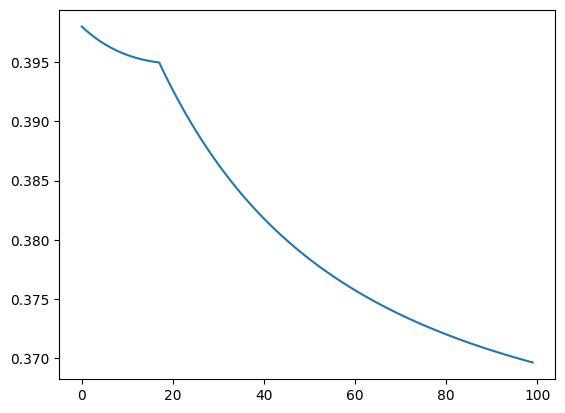

In [8]:
plt.plot(losses)

In [9]:
#检验结果
probs_val = sigmoid(best_logits_valid)
print("Best epoch: {}".format(best_epoch))
print("Best acc for heldout data during training: {}".format(best_acc))
print("Valid set whole acc: {}".format(np.mean((probs_val>0.5)==y_val)))
print("Previous acc: {}".format(np.mean((db["ydm_train"]>0.5)==y_val)))
print("Test set acc: {}".format(np.mean((sigmoid(predicted_test_logits)>0.5)==db["y_test"])))
print("Previous acc: {}".format(np.mean((db["ydm_test"]>0.5)==db["y_test"])))

Best epoch: 10
Best acc for heldout data during training: 0.8583333333333333
Valid set whole acc: 0.8331180465852744
Previous acc: 0.8347847826992791
Test set acc: 0.8256957173804366
Previous acc: 0.8258623562739543


# Now, do the fairness comparison

In [10]:
#Huangrui add
EPS = 1e-8
Y_hat = sigmoid(predicted_test_logits)>0.5
A = db["attr_test"]
Y = db["y_test"]
TP = np.multiply(Y, Y_hat)
mask0 = np.multiply(Y,1-A)
mask1 = np.multiply(Y,A)
TP0 = np.multiply(TP, mask0)
TP1 = np.multiply(TP, mask1)
tpr0 = np.sum(TP0) / (np.sum(mask0) + EPS)
tpr1 = np.sum(TP1) / (np.sum(mask1) + EPS)
print(tpr0)
print(tpr1)
#get the error rate of the test set
error_rate = np.mean(Y_hat != Y)
print("Error rate is {}".format(error_rate))
print("Equal opportunity difference is {}".format(abs(tpr0-tpr1)))

0.49058149057747275
0.3628691982969253
Error rate is 0.1743042826195634
Equal opportunity difference is 0.12771229228054742


In [12]:
#Huangrui add
# EPS = 0
Y_hat = sigmoid(test_logits)>0.5
A = db["attr_test"]
Y = db["y_test"]
TP = np.multiply(Y, Y_hat)
mask0 = np.multiply(Y,1-A)
mask1 = np.multiply(Y,A)
TP0 = np.multiply(TP, mask0)
TP1 = np.multiply(TP, mask1)
tpr0 = np.sum(TP0) / (np.sum(mask0) + EPS)
tpr1 = np.sum(TP1) / (np.sum(mask1) + EPS)
print(tpr0)
print(tpr1)
#get the error rate of the test set
error_rate = np.mean(Y_hat != Y)
print("Error rate is {}".format(error_rate))
print("Equal opportunity difference is {}".format(abs(tpr0-tpr1)))

0.4905814905814906
0.3628691983122363
Error rate is 0.1743042826195634
Equal opportunity difference is 0.1277122922692543


In [15]:
Y_hat_pre = db["ydm_test"]>0.5
A = db["attr_test"]
Y = db["y_test"]
TP = np.multiply(Y, Y_hat_pre)
mask0 = np.multiply(Y,1-A)
mask1 = np.multiply(Y,A)
TP0 = np.multiply(TP, mask0)
TP1 = np.multiply(TP, mask1)
tpr0 = np.sum(TP0) / (np.sum(mask0) + EPS)
tpr1 = np.sum(TP1) / (np.sum(mask1) + EPS)
print(tpr0)
print(tpr1)
#get the error rate of the test set
error_rate = np.mean(Y_hat_pre != Y)
print("Error rate is {}".format(error_rate))
print("Equal opportunity difference is {}".format(abs(tpr0-tpr1)))


0.5004095004095004
0.3080168776371308
Error rate is 0.17413764372604565
Equal opportunity difference is 0.19239262277236957
